# Car Price prediction 

# Let's explore the data and try to predict the price based on the features

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings


warnings.filterwarnings('ignore')

sns.set_palette('pastel')

# Loading and checking the data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/danielnavarro2911/Car-prices/main/CarPrice_Assignment.csv")

In [4]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [2]:
df.info()
#No missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

# Correlation between the features
Here we can see there are severeal features that are strongly correlated with the price

We can try to reduce the dimension of the data by looking for the most correlated variables.

<Axes: >

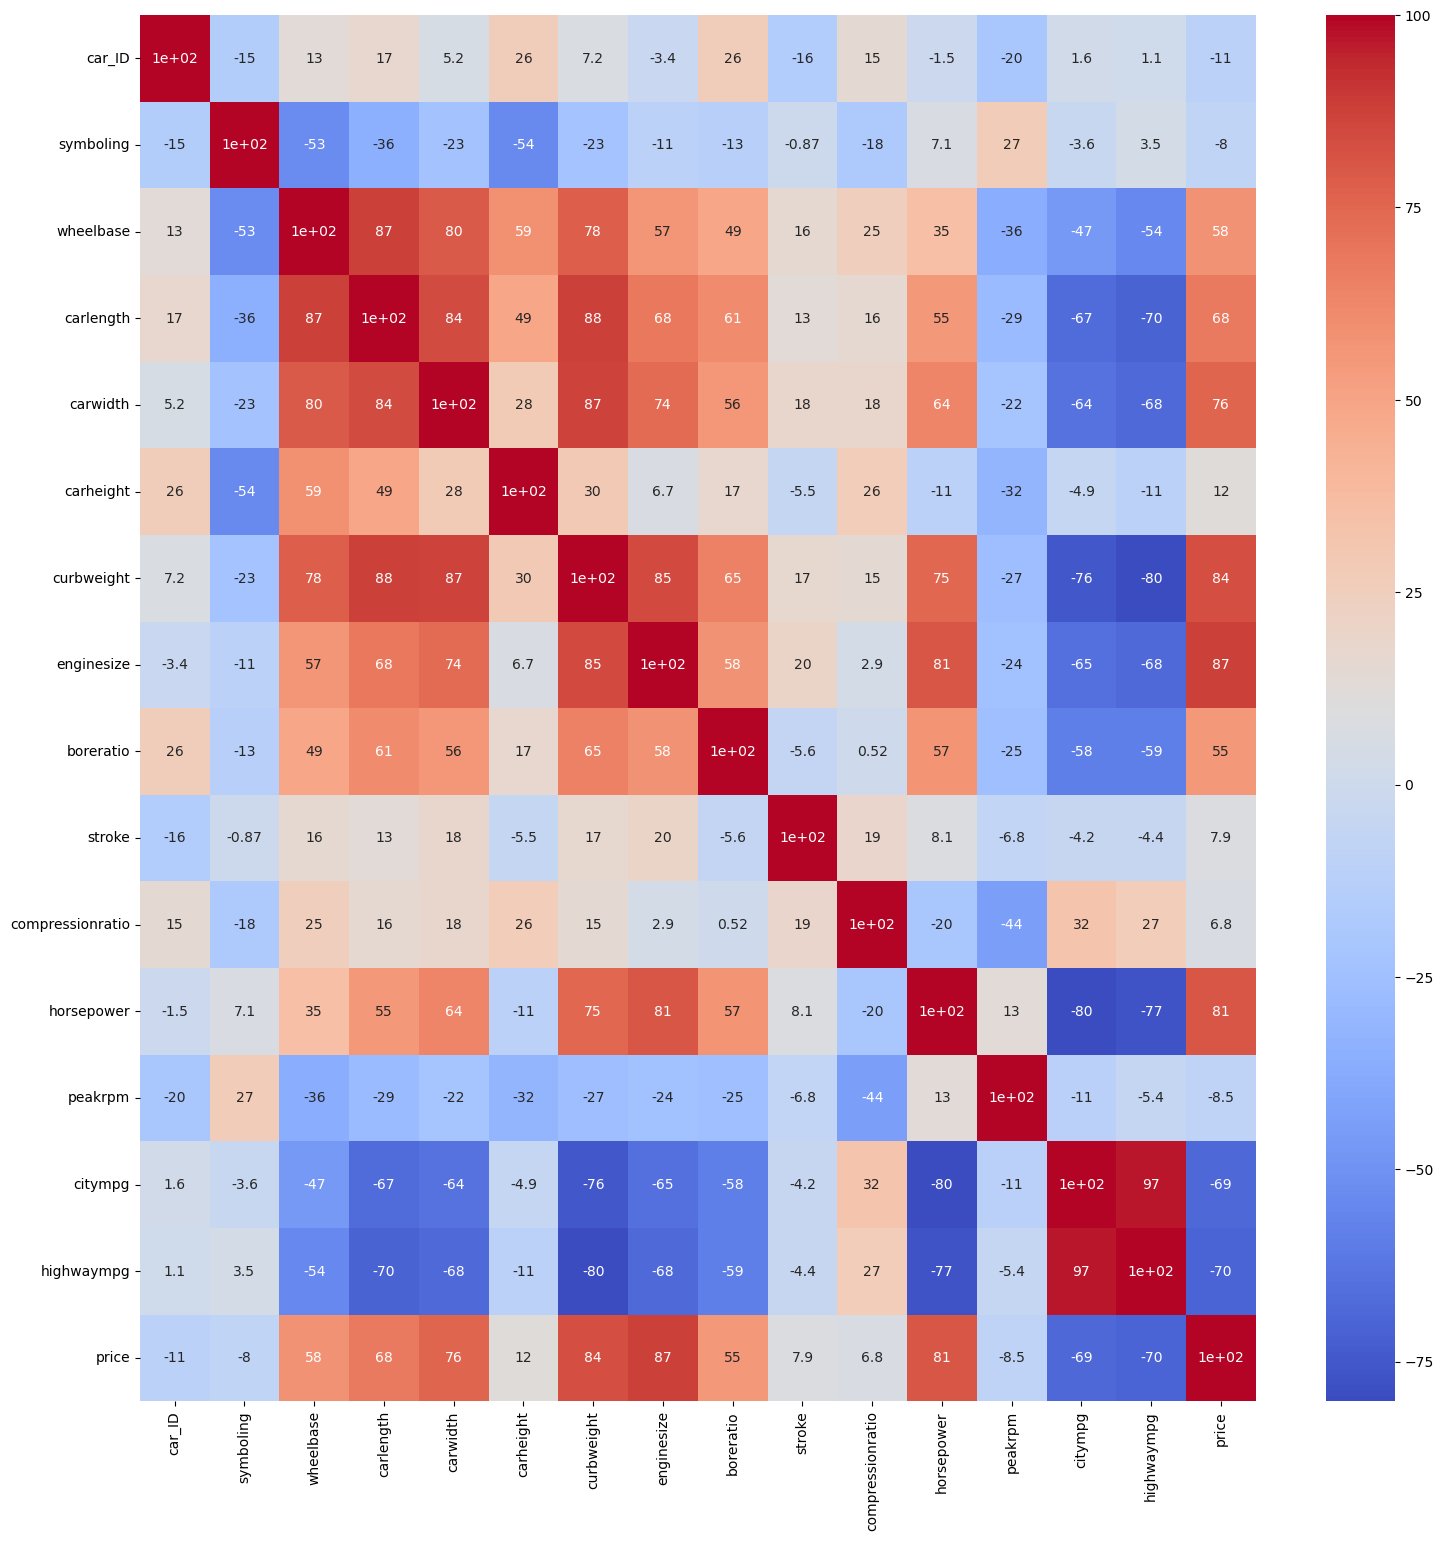

In [3]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr()*100,annot=True,cmap='coolwarm')

# The 10 most correlated features:

In [4]:
abs(df.corr()).nlargest(10,'price',)['price']

price         1.000000
enginesize    0.874145
curbweight    0.835305
horsepower    0.808139
carwidth      0.759325
highwaympg    0.697599
citympg       0.685751
carlength     0.682920
wheelbase     0.577816
boreratio     0.553173
Name: price, dtype: float64

In [5]:
corrcolumns=abs(df.corr()).nlargest(10,'price',)[['price']].index

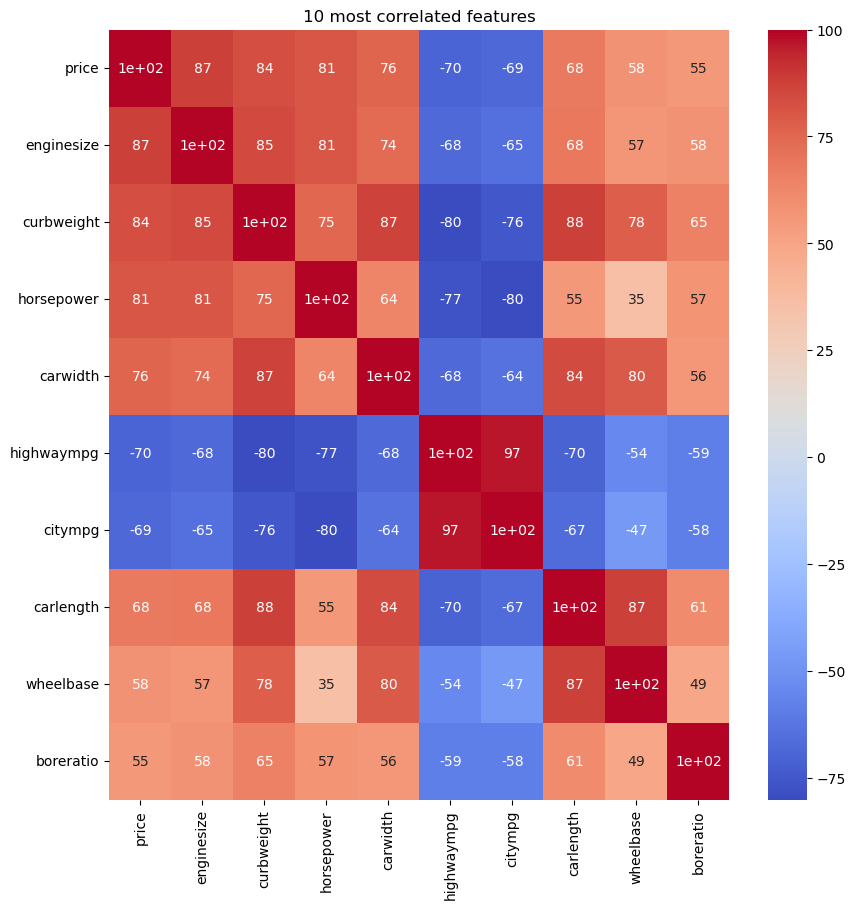

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df[corrcolumns].corr()*100,annot=True,cmap='coolwarm')
plt.title('10 most correlated features')
plt.show()

Here we can see that price is strongly correlated with these features, but at the same time, these features are strongly correlated with each other, so we can remove some of them.

For example, engine size and horsepower are highly correlated with price, but at the same time, engine size is strongly correlated with horsepower, which makes sense! If you have a high horsepower engine, this will probably be too big. We can drop one, and keep the other


Let's drop the non-correlated feautures

In [7]:
df.drop(list(df.corr()[abs(df.corr()['price']*100)<=48][['price']].index),axis=1,inplace=True)

Now,drop the features correlated with each other more than 80%

In [8]:
corrcolumns=list(corrcolumns)
corrcolumns.remove('price')
corr=df[corrcolumns].corr()*100
for i in corrcolumns:
    try:
        drop=corr[(abs(corr[i]>=80)) & (abs(corr[i]!=100))].index
        corr.drop(drop,axis=1,inplace=True)
        df.drop(drop,axis=1,inplace=True)
    except:
        pass

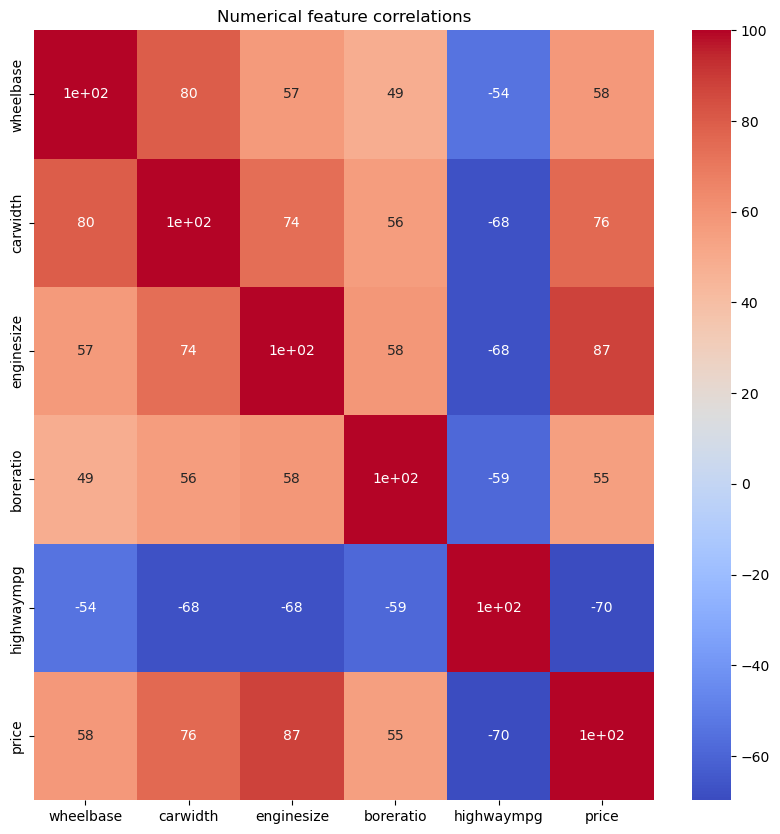

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()*100,annot=True,cmap='coolwarm')
plt.title('Numerical feature correlations')
plt.show()

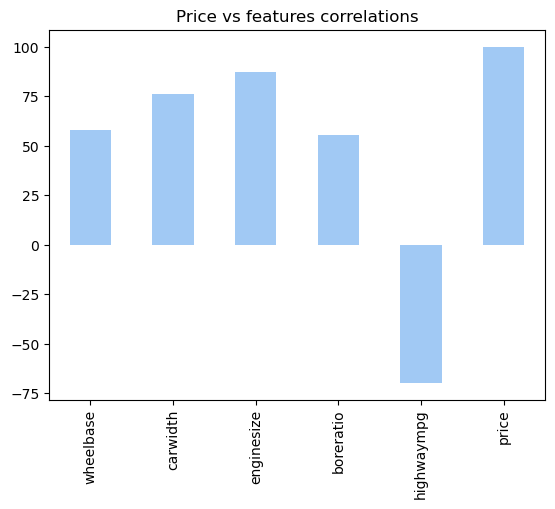

In [10]:
(df.corr()['price']*100).plot.bar()
plt.title("Price vs features correlations")
plt.show()

## We have greatly reduced the dimension of our data set!

Let's look at the relationship between price and these features.

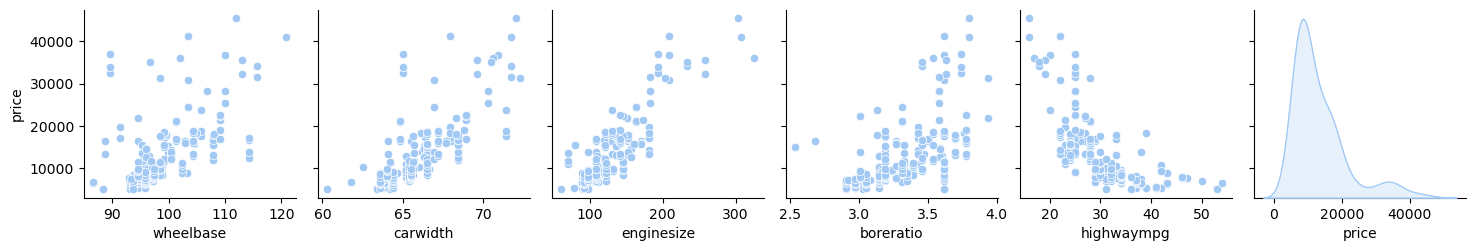

In [11]:
sns.pairplot(df.select_dtypes(include=['float64', 'int64']), x_vars=df.select_dtypes(include=['float64', 'int64']).columns, y_vars=['price'], kind='scatter', diag_kind='kde')
plt.show()


This suggests that a linear regression is well placed.

### And finally, the price distribution

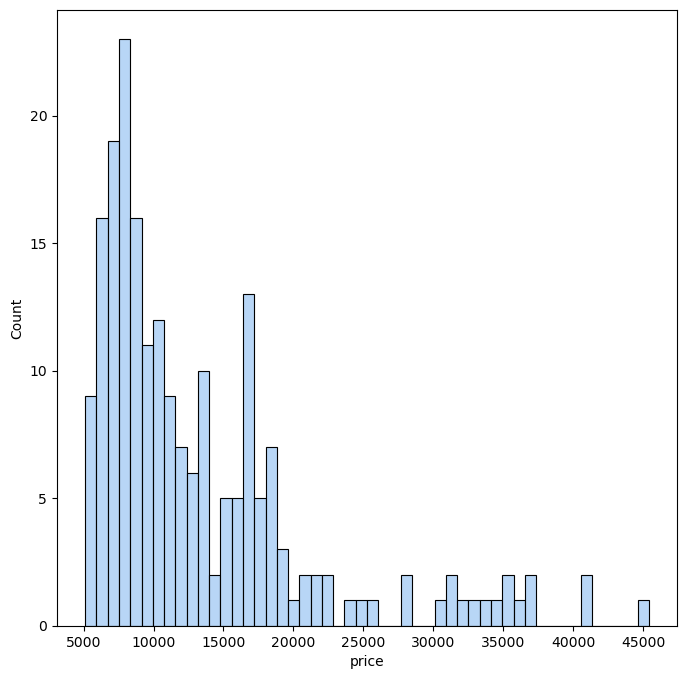

In [12]:
plt.figure(figsize=(8,8))
sns.histplot(df['price'],bins=50)
plt.show()

In [13]:
df[['price']].describe()

,price
count,205.000000
mean,13276.710571
std,7988.852332
min,5118.000000
25%,7788.000000
50%,10295.000000
75%,16503.000000
max,45400.000000



# Now, let's pay attention to the categorical characteristic

We have 147 unique names on CarName

In [14]:
df.select_dtypes(include=['object']).apply(lambda x: x.nunique())

CarName           147
fueltype            2
aspiration          2
doornumber          2
carbody             5
drivewheel          3
enginelocation      2
enginetype          7
cylindernumber      7
fuelsystem          8
dtype: int64

In [15]:
df[['CarName']]

,CarName
0,alfa-romero giulia
1,alfa-romero stelvio
2,alfa-romero Quadrifoglio
3,audi 100 ls
4,audi 100ls
...,...
200,volvo 145e (sw)
201,volvo 144ea
202,volvo 244dl
203,volvo 246


As we can see, CarName follows the structure: "Brand Model". Let's create a new column called "Brand"

In [16]:
df['Brand']=df['CarName'].map(lambda x:x.split()[0].lower())
df.drop('CarName',axis=1,inplace=True)

There are some typos that shoud be fixed manually

In [17]:
def brand(x):
    if x=='maxda':
        return 'mazda'
    if x=='porcshce':
        return 'porsche'
    if x=='toyouta':
        return 'toyota'
    if x=='vokswagen':
        return 'volkswagen'
    else:
        return x
        

In [18]:
df['Brand']=df['Brand'].map(brand)

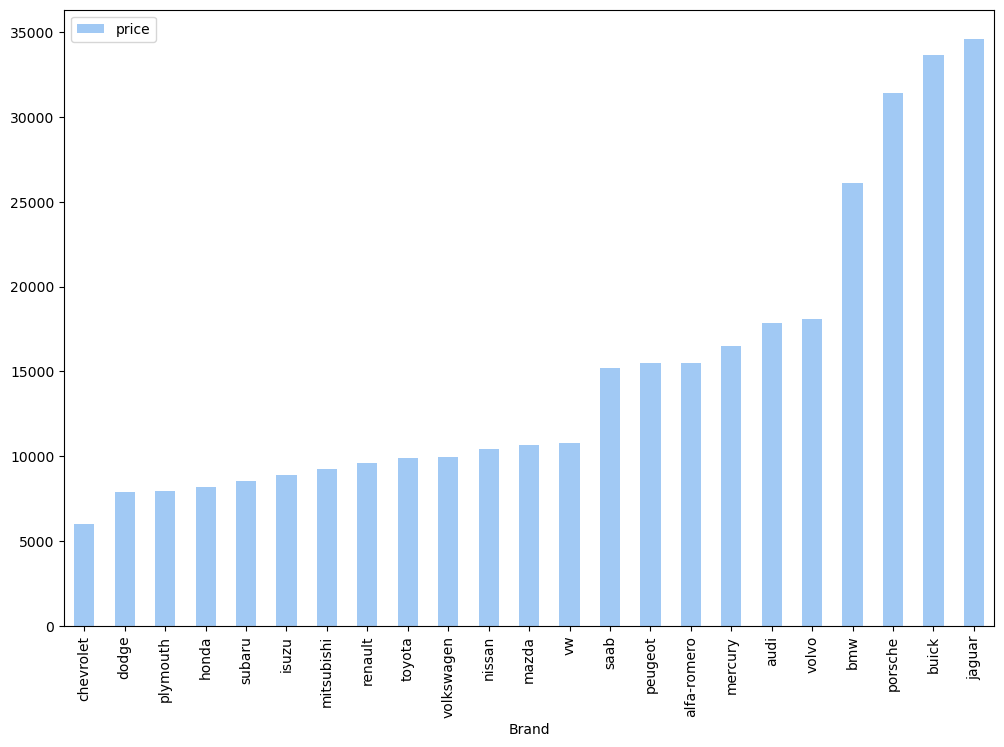

In [19]:
df.groupby('Brand').mean()[['price']].sort_values('price').plot.bar(figsize=(12,8))
plt.show()

Check the relationship between categorical feature vs price

In [20]:
category=df.select_dtypes(include=['object'])

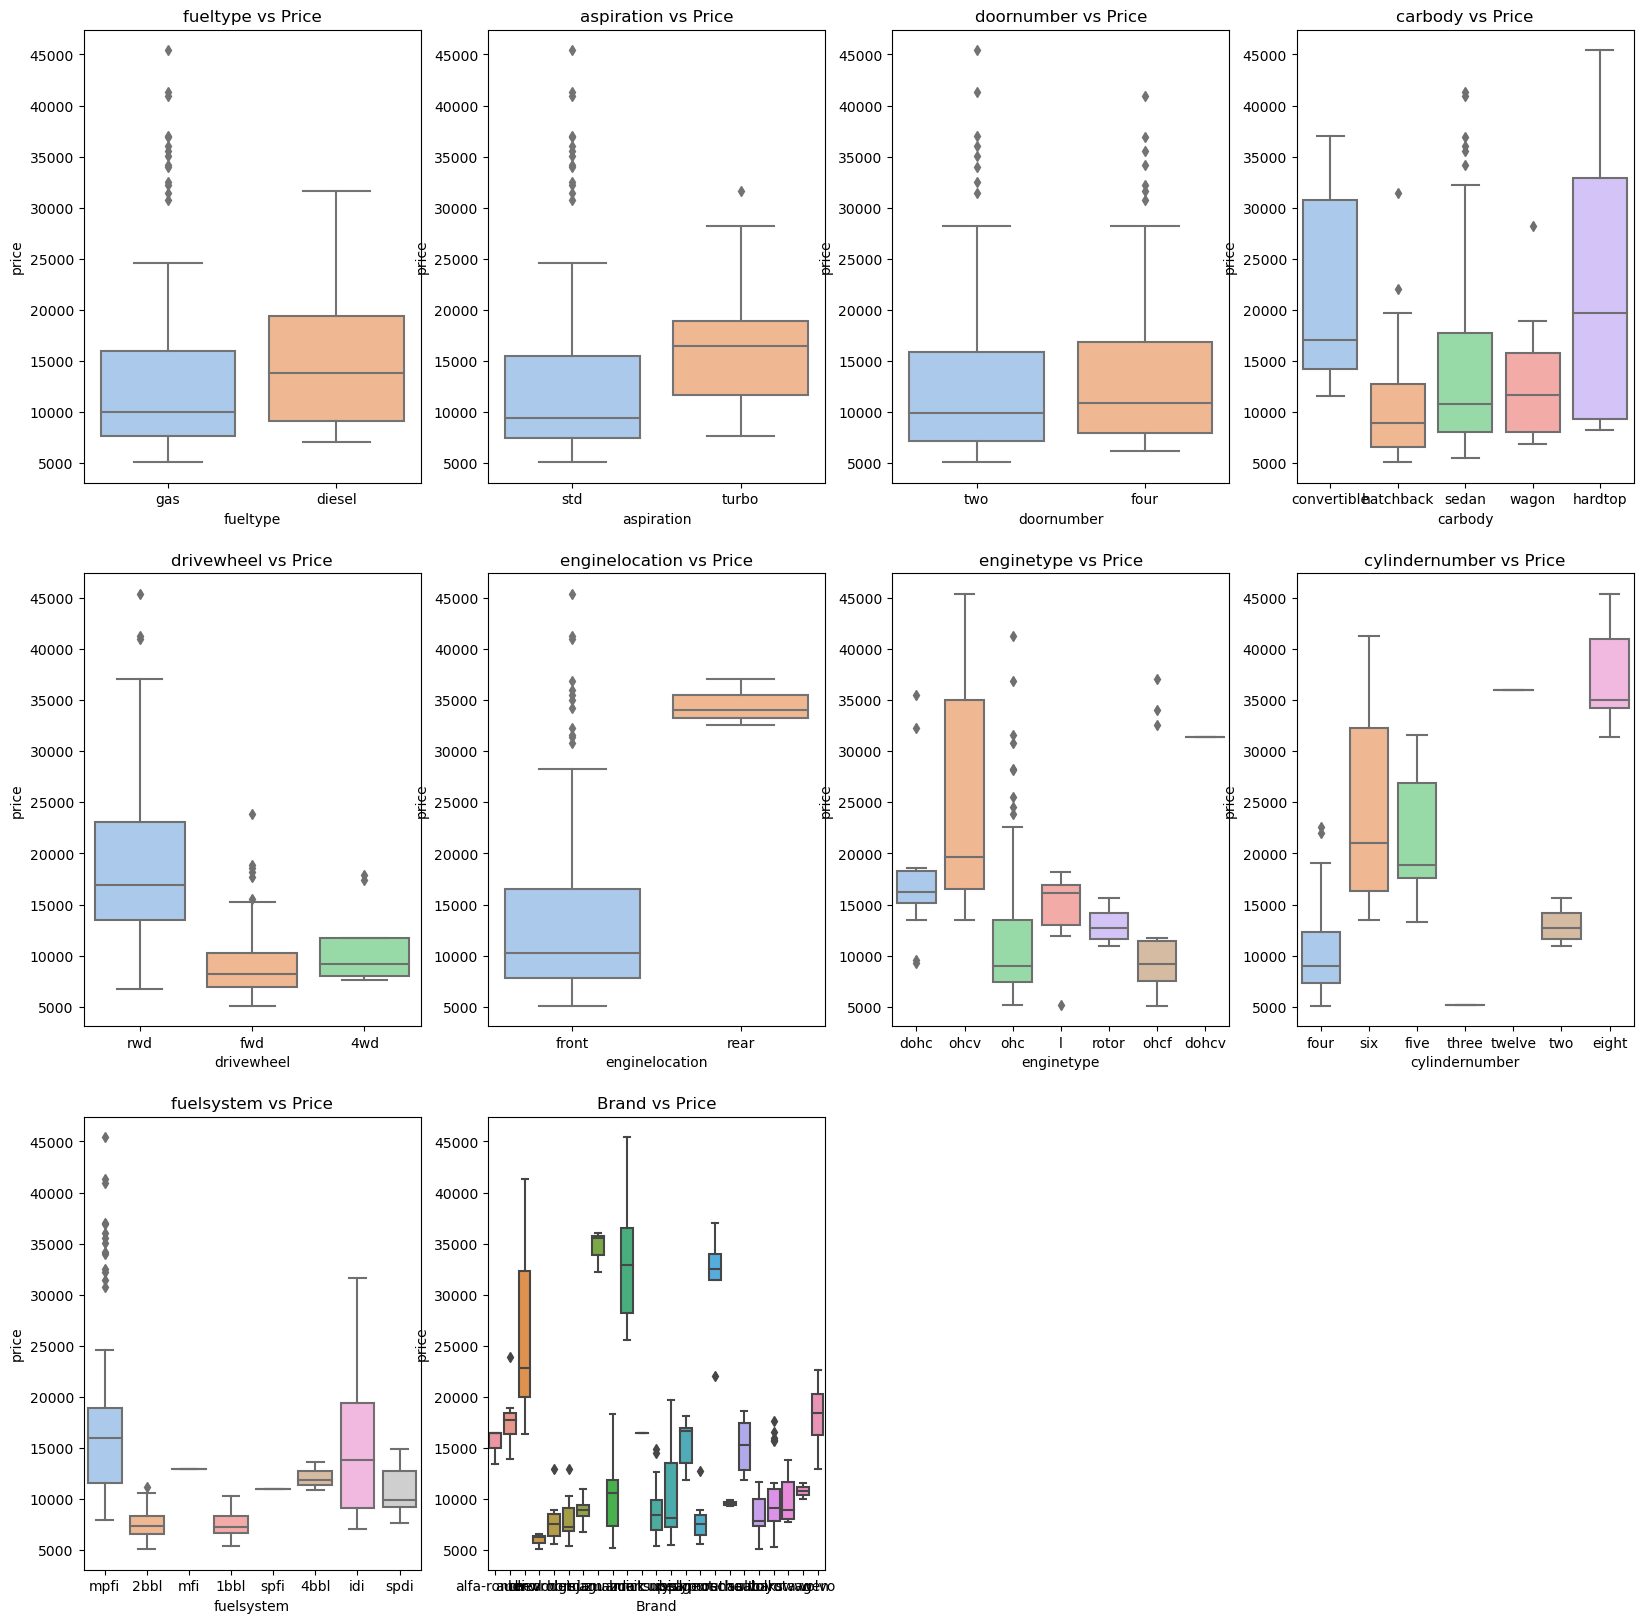

In [21]:
plt.figure(figsize=(20, 20))
for i in category:
    plt.subplot(3, 4, list(category.columns).index(i) + 1)
    sns.boxplot(data=df, x=i, y='price')
    plt.title(i+' vs Price')

plt.show()

Getting closer to the brand vs. price and orders

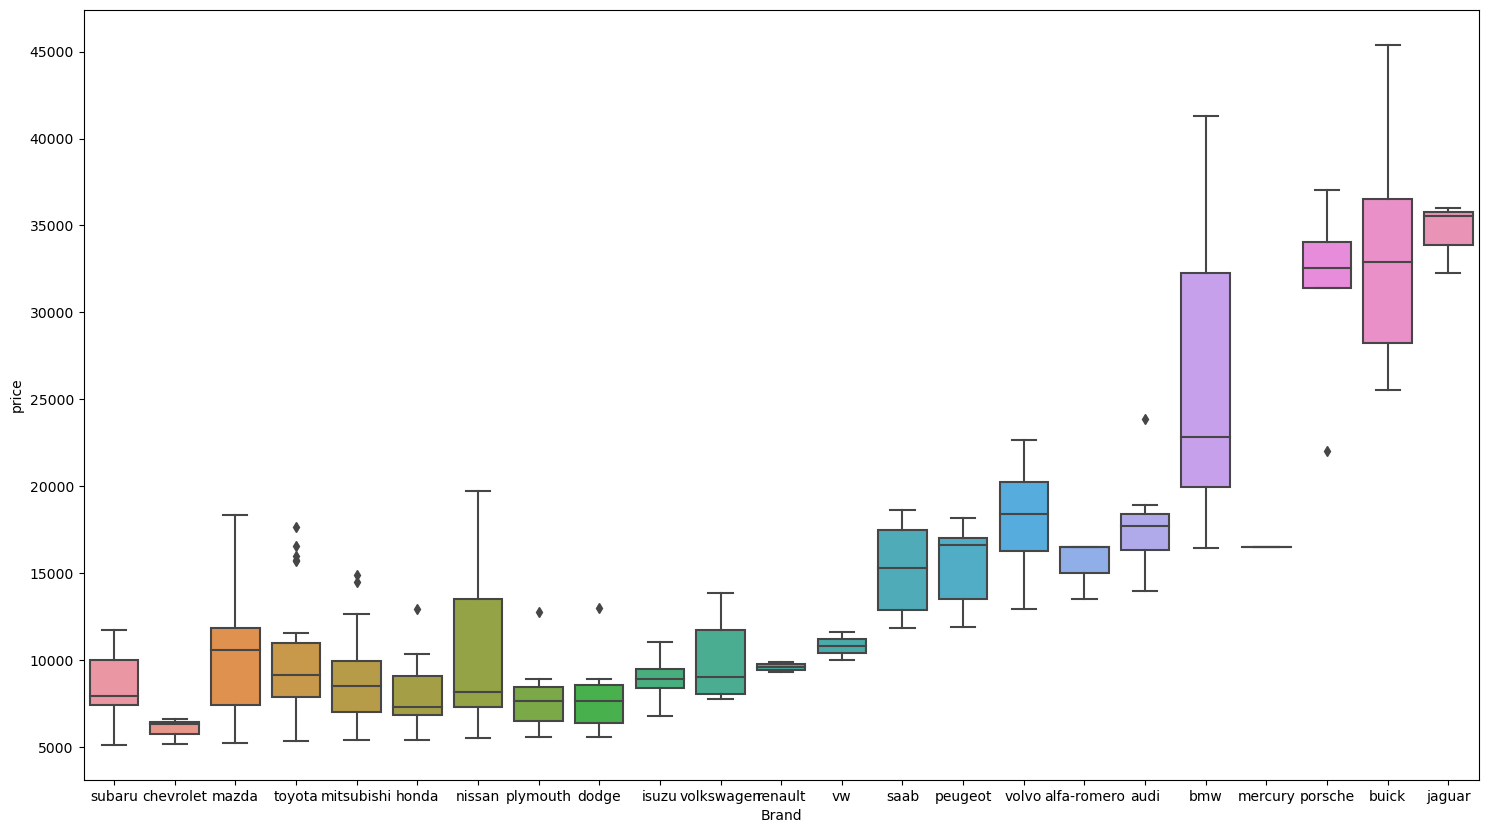

In [22]:
plt.figure(figsize=(18,10))
sns.boxplot(x='Brand',y='price',data=df.sort_values('price'))
plt.show()

And the distribution

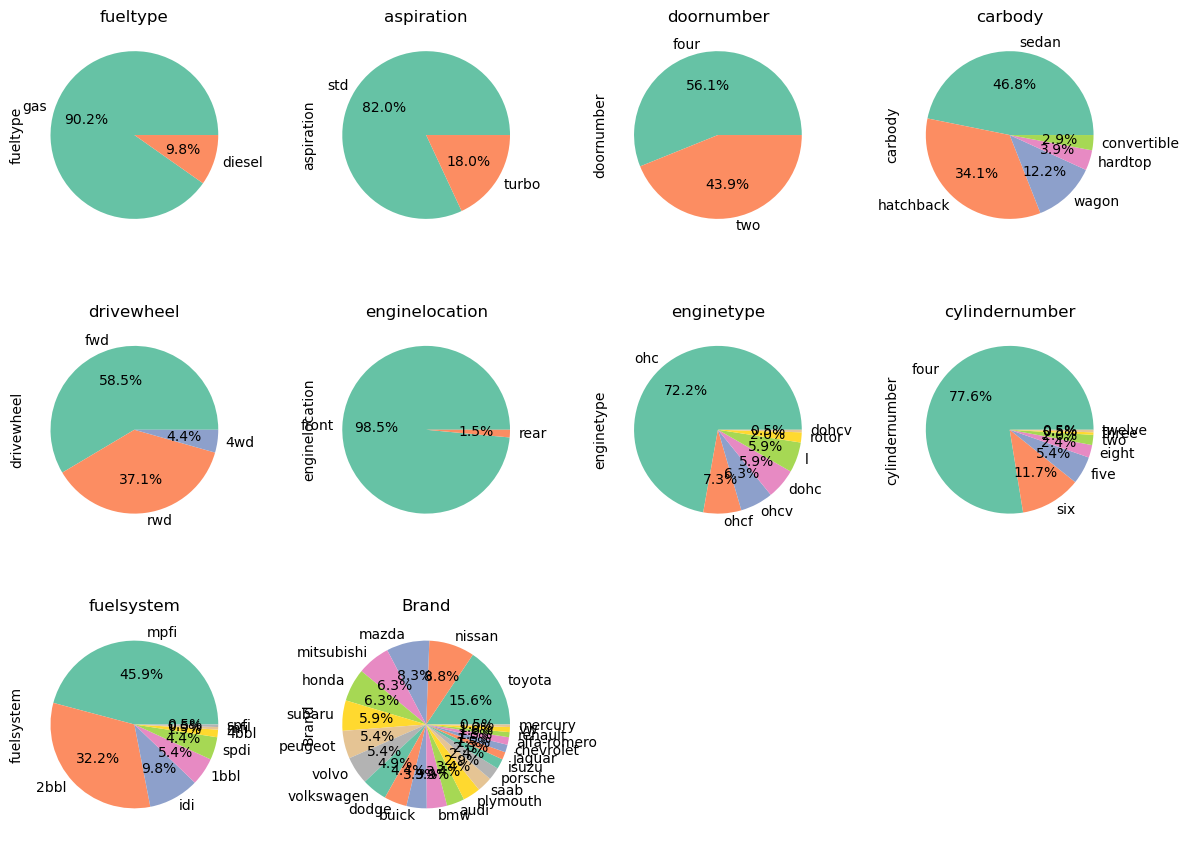

In [23]:
num_rows, num_cols = 3, 4
num_plots = num_rows * num_cols

# calculate the real number of graphs
num_plots_to_generate = min(num_plots, len(category.columns))


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 9))

for i, column in enumerate(category.columns):
    if i < num_plots_to_generate:  # Generate if there are enough columns
        ax = axes[i // num_cols, i % num_cols]
        category[column].value_counts().plot.pie(ax=ax,autopct='%1.1f%%',colors = plt.cm.Set2.colors)
        ax.set_title(f'{column}')


# hide the empty axes
for i in range(num_plots_to_generate, num_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# Predicting the price

Let's convert the categorical data to numeric data

In [24]:
df_encode=pd.get_dummies(df,drop_first=False)

## Training a Linear Regression Model

Let's now begin to train out regression model! We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column.

### X and y arrays

In [25]:
X = df_encode.drop('price',axis=1)
y = df_encode['price']

### Train Test Split

Now let's split the data into a training set and a testing set.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Creating and Training the Model

In [27]:
lm = LinearRegression()

In [28]:
lm.fit(X_train,y_train)

LinearRegression()

### Model Evaluation

In [29]:
predictions = lm.predict(X_test)

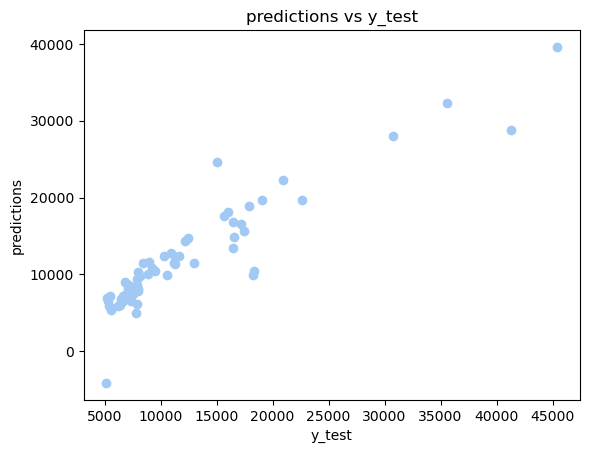

In [30]:
plt.scatter(y_test,predictions)
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.title('predictions vs y_test')
plt.show()

#### We got almost a straight line!
This means that there was a good prediction since the model is capturing well the relationship between the features and price.

### Let's explore the distribution of prediction errors

the closer to zero, the smaller the error.

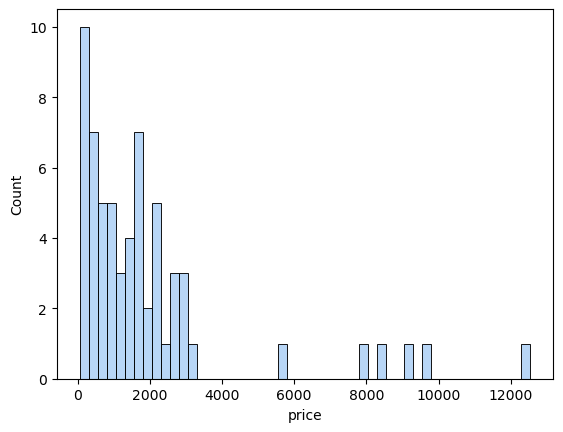

In [31]:
sns.histplot(abs(y_test-predictions),bins=50);

## Metrics

In [32]:
print('r2:', metrics.r2_score(y_test,predictions)*100)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

r2: 84.96005977349735
RMSE: 3205.3175572654263


### Finally we have achieved R2 score of 85 on our test data. This signifies that our model is successful in explaining around 85% of the variability in price using these features. 

### Additionally, the root mean squared error (RMSE) of approximately $3200 tells us that, on average, our predictions deviate by this amount from the actual car prices in the test dataset, which is acceptable taking into account that we are talking about car prices